In [1]:
from qick import *

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D
from qick.asm_v2 import QickProgramV2, AcquireProgramV2

# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# # soc = QickSoc('../../qick_lib/qick/qick_4x2.bit')
# soc = QickSoc('../../firmware/pynq_files/qick_4x2_jac.bit')
# # soc = QickSoc('../../qick_lib/qick/qick_4x2.bit',force_init_clks=True)

# print(soc)
# print(soc.tproc)

In [3]:
from qick.pyro import make_proxy
# soc, soccfg = make_proxy(ns_host="pynq4x2.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
# soc, soccfg = make_proxy(ns_host="pynq216.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
soc, soccfg = make_proxy(ns_host="pynq111-2.dhcp.fnal.gov", ns_port=8888, proxy_name="myqick")
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_3184ea374bb14a0ca881f8cc957ab20b@131.225.82.18:42239

QICK configuration:

	Board: ZCU111

	Software version: 0.2.233
	Firmware timestamp: Tue Feb 13 19:05:43 2024

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	8 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is DAC228_T0_CH1 or RF board output 1
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 2 is DAC228_T0_CH2 or RF board output 2
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric

In [4]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')

In [5]:
# use pyro's traceback code instead of ipython's
# adapted from https://pyro4.readthedocs.io/en/stable/errors.html and https://stackoverflow.com/a/70433500
import IPython
import Pyro4.util
import sys

from IPython import get_ipython
ip = get_ipython()

def exception_handler(self, etype, evalue, tb, tb_offset=None):
    sys.stderr.write("".join(Pyro4.util.getPyroTraceback()))
    # self.showtraceback((etype, evalue, tb), tb_offset=tb_offset)  # standard IPython's printout

ip.set_custom_exc((Exception,), exception_handler)  # register your handler

In [6]:
# ZCU111
GEN_CH = 7
RO_CH = 0
TRIG_TIME = 0.30
FREQ = 1000

## debugging

     REG_WR s12 imm #0 
     TIME #384 inc_ref 
     REG_WR r0 imm #1000 
REPS:
     REG_WR s14 imm #0 
     WPORT_WR p7 wmem [&0] 
     REG_WR s14 imm #115 
     DPORT_WR p1 imm 1 
     DPORT_WR p0 imm 1 
     REG_WR s14 imm #125 
     DPORT_WR p1 imm 0 
     DPORT_WR p0 imm 0 
     WAIT [&13] @3993 
     DPORT_RD p0 
     DMEM_WR [s12] op -op(s8) 
     WAIT [&17] @153 
     TIME #38553 inc_ref 
     REG_WR s12 op -op(s12 + #1) 
     REG_WR r0 op -op(r0-#1) -uf 
     JUMP REPS -if(NZ) 
     JUMP HERE 



  0%|          | 0/1000 [00:00<?, ?it/s]

mismatched indices: [ 38  90 111 154 218 282 288 334 342 349 392 410 585 598 648 673 771 835
 879 899 907 929 971 990]


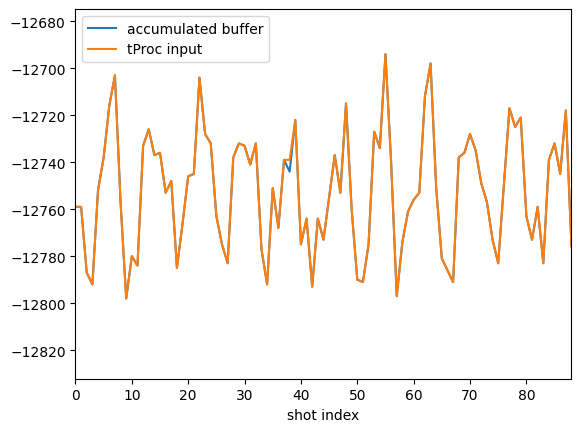

In [7]:
# normal program similar to 00_intro - pulse, readout, copy input to data mem
class ReadProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])
        self.wait_auto(cfg['read_wait'])
        self.read(cfg['ro_ch'])
        self.asm_inst({'CMD': 'DMEM_WR', 'SRC': 'op', 'OP': 's8', 'DST': '[s12]'})

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          # 'read_wait': 0.1,
          'read_wait': 10,
          'ro_len': 0.1,
          'flat_len': 0.025,
          'phase': 0,
          'gain': 1.0
         }

reps = 1000
prog = ReadProgram(soccfg, reps=reps, final_delay=100.0, cfg=config)

print(prog.asm())

iq_list = prog.acquire(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)

accumulated = prog.get_raw()[0][:,0,0]
feedback = soc.tproc.read_mem(2,0,reps)[:,0]
mismatches = (accumulated-feedback).nonzero()[0]
print("mismatched indices:", mismatches)
plt.plot(accumulated, label="accumulated buffer")
plt.plot(feedback, label="tProc input")
if len(mismatches)>0:
    r = (max(0, mismatches[0]-50), min(reps, mismatches[0]+50))
    plt.xlim(r)

plt.legend()
plt.xlabel("shot index");


     REG_WR s12 imm #0 
     TIME #384 inc_ref 
     REG_WR r0 imm #1000 
REPS:
     REG_WR s14 imm #0 
     DPORT_WR p1 imm 1 
     REG_WR s14 imm #10 
     DPORT_WR p1 imm 0 
     WAIT [&9] @3878 
     DPORT_RD p0 
     DMEM_WR [s12] op -op(s8) 
     WAIT [&13] @38 
     TIME #38438 inc_ref 
     REG_WR s12 op -op(s12 + #1) 
     REG_WR r0 op -op(r0-#1) -uf 
     JUMP REPS -if(NZ) 
     JUMP HERE 



  0%|          | 0/1000 [00:00<?, ?it/s]

mismatched indices: [ 21  81 101 245 307 360 453 462 484 546 707 715 789 799 807 852 866 883
 884 899 906 945 949 959 976 983 991]


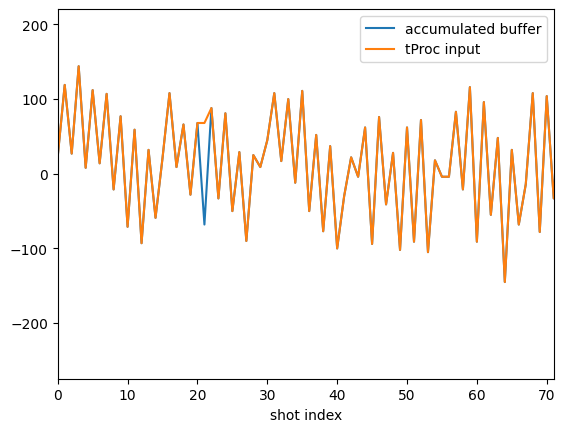

In [8]:
# minimal - get rid of the pulse, we can still see the effect when reading noise

class ReadProgram(AveragerProgramV2):
    def initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'], freq=0)
        
    def body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], t=0)
        self.wait_auto(cfg['read_wait'])
        # self.asm_inst({'CMD':'REG_WR', 'DST':'s8','SRC':'imm','LIT':'1000'})
        self.read(cfg['ro_ch'])
        self.asm_inst({'CMD': 'DMEM_WR', 'SRC': 'op', 'OP': 's8', 'DST': '[s12]'})

config = {'ro_ch': RO_CH,
          # 'read_wait': 0.1,
          'read_wait': 10,
          'ro_len': 0.1,
         }

reps = 1000
prog = ReadProgram(soccfg, reps=reps, final_delay=100.0, cfg=config)

print(prog.asm())

iq_list = prog.acquire(soc, soft_avgs=1)

accumulated = prog.get_raw()[0][:,0,0]
feedback = soc.tproc.read_mem(2,0,reps)[:,0]
mismatches = (accumulated-feedback).nonzero()[0]
print("mismatched indices:", mismatches)

plt.plot(accumulated, label="accumulated buffer")
plt.plot(feedback, label="tProc input")
# if we find mismatches, zoom in to the first one
if len(mismatches)>0:
    r = (max(0, mismatches[0]-50), min(reps, mismatches[0]+50))
    plt.xlim(r)
plt.legend()
plt.xlabel("shot index");


  0%|          | 0/100 [00:00<?, ?it/s]

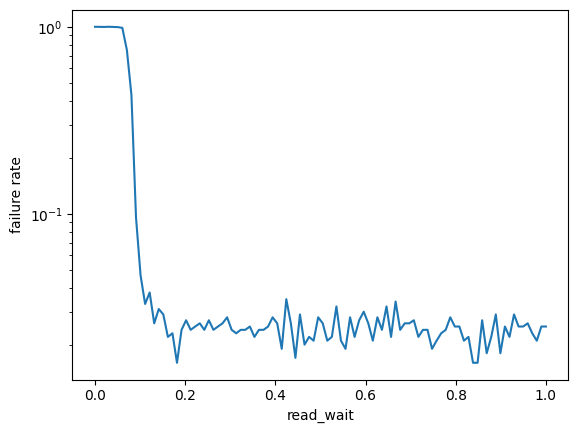

In [23]:
# sweep the wait, count mismatches
# as expected, there is some latency threshold and if you wait less than that you always fail
# but above the threshold the failure rate never goes to 0

from tqdm.auto import tqdm
config = {'ro_ch': RO_CH,
          # 'read_wait': 0.1,
          'read_wait': 10,
          'ro_len': 0.1,
         }

waits = np.linspace(0,1.0,100)
fails = np.zeros_like(waits)
reps = 1000
for i, wait in enumerate(tqdm(waits)):
    config['read_wait'] = wait
    prog = ReadProgram(soccfg, reps=reps, final_delay=100.0, cfg=config)
    
    iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
    
    accumulated = prog.get_raw()[0][:,0,0]
    feedback = soc.tproc.read_mem(2,0,reps)[:,0]
    
    mismatches = (accumulated-feedback).nonzero()[0]

    fails[i] = len(mismatches)

plt.semilogy(waits, fails/reps)
plt.ylabel("failure rate")
plt.xlabel("read_wait");


text ASM:
     REG_WR s12 imm #0 
     REG_WR r0 imm #1000 
MYLOOP:
     REG_WR s14 imm #0 
     DPORT_WR p1 imm 1 
     REG_WR s14 imm #10 
     DPORT_WR p1 imm 0 
     WAIT [&8] @3878 
     DPORT_RD p0 
     DMEM_WR [s12] op -op(s8) 
     REG_WR s12 op -op(s12 + #1) 
     TIME #38400 inc_ref 
     REG_WR r0 op -op(r0-#1) -uf 
     JUMP MYLOOP -if(NZ) 
     JUMP HERE 



  0%|          | 0/1000 [00:00<?, ?it/s]

mismatched indices: [ 74  89 120 126 151 679 749 922]


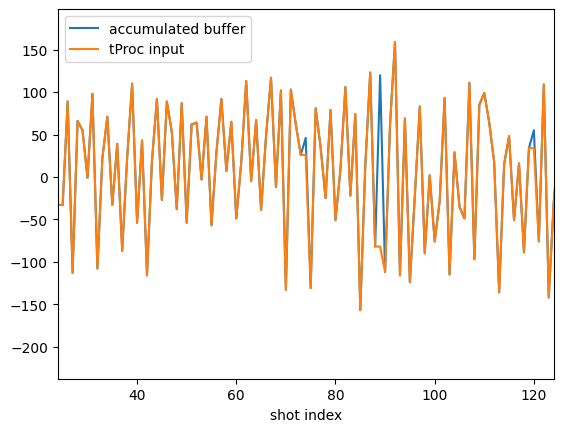

In [9]:
# use AcquireProgramV2 so all the instructions are visible

from qick.asm_v2 import AcquireProgramV2

reps = 1000

prog = AcquireProgramV2(soccfg)
prog.declare_readout(ch=RO_CH, length=0.1, freq=0)

prog.set_ext_counter(addr=1, val=0)
prog.open_loop(reps, "myloop")

prog.trigger(ros=[RO_CH], t=0)
prog.wait_auto(10.0) # 10 us
# prog.asm_inst({'CMD':'REG_WR', 'DST':'s8','SRC':'imm','LIT':'1000'})
prog.read(RO_CH)
prog.asm_inst({'CMD': 'DMEM_WR', 'SRC': 'op', 'OP': 's8', 'DST': '[s12]'})
prog.inc_ext_counter(addr=1, val=1)
prog.delay(100.0) # 100 us

prog.close_loop()
prog.end()

prog.setup_acquire(counter_addr=1, loop_dims=[reps], avg_level=0)
prog.set_reads_per_shot(1)

print("text ASM:")
print(prog.asm())
# print("machine code:")
# for a in prog.compile()['pmem']:
#     print([hex(b) for b in a])

prog.acquire(soc)

accumulated = prog.get_raw()[0][:,0,0]
feedback = soc.tproc.read_mem(2,0,reps)[:,0]
mismatches = (accumulated-feedback).nonzero()[0]
print("mismatched indices:", mismatches)

plt.plot(accumulated, label="accumulated buffer")
plt.plot(feedback, label="tProc input")
# if we find mismatches, zoom in to the first one
if len(mismatches)>0:
    r = (max(0, mismatches[0]-50), min(reps, mismatches[0]+50))
    plt.xlim(r)
plt.legend()
plt.xlabel("shot index");
